# Demo Notebook

## Setup

---


In [1]:
import numpy as np
import pandas as pd
import grama as gr
%matplotlib inline

DF = gr.Intention()

# For downloading data
import os
import requests


## Download Data


In [2]:
# Filename for local data
filename_data = "./data/tabula-weibull.csv"

# The following code downloads the data, or (after downloaded)
# loads the data from a cached CSV on your machine
if not os.path.exists(filename_data):
    # Make request for data
    url_data = "https://raw.githubusercontent.com/zdelrosario/mi101/main/mi101/data/tabula-weibull1939-table4.csv"
    r = requests.get(url_data, allow_redirects=True)
    open(filename_data, 'wb').write(r.content)
    print("   Tabula-extracted data downloaded from public Google sheet")
else:
    # Note data already exists
    print("   Tabula-extracted data loaded locally")
    
# Read the data into memory
df_raw = pd.read_csv(filename_data)


   Tabula-extracted data loaded locally


## Tidy and Wrangle Data

---


In [3]:
df_raw.head()


,No.,Area mm^2,sigma_d kg/mm^2,No..1,Area mm^2.1,sigma_d kg/mm^2.1
0,1,21.50,0.61,14.0,23.10,0.58
1,2,22.31,0.60,15.0,21.91,0.62
2,3,23.00,0.50,16.0,23.23,0.50
3,4,14.18,0.63,17.0,25.80,0.50
4,5,22.03,0.48,18.0,20.68,0.52


In [4]:
df_weibull = (
    df_raw
    >> gr.tf_rename(
        obs_1="No.",
        area_1="Area mm^2",
        sigma_1="sigma_d kg/mm^2",
        obs_2="No..1",
        area_2="Area mm^2.1",
        sigma_2="sigma_d kg/mm^2.1",
    )
    >> gr.tf_pivot_longer(
        columns=["obs_1", "area_1", "sigma_1", "obs_2", "area_2", "sigma_2"],
        names_to=[".value", "block"],
        names_sep="_"
    )
    >> gr.tf_filter(gr.not_nan(DF.sigma))
)

df_weibull.head()

,block,area,obs,sigma
0,1,21.50,1.0,0.61
1,2,23.10,14.0,0.58
2,1,22.31,2.0,0.60
3,2,21.91,15.0,0.62
4,1,23.00,3.0,0.50


## Visualize

---


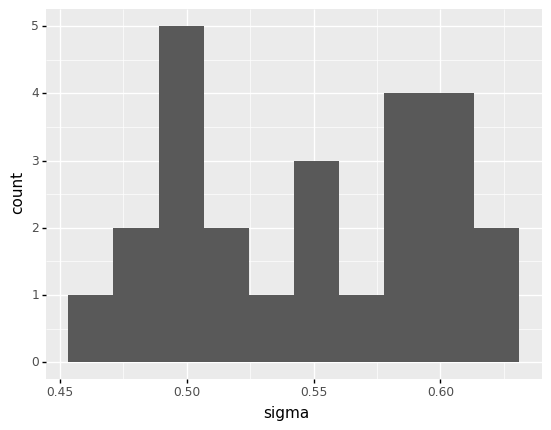

<ggplot: (8768192664182)>

In [5]:
(
    df_weibull
    >> gr.ggplot(gr.aes("sigma"))
    + gr.geom_histogram(bins=10)
)

## Model

---


eval_sample() is rounding n...
Design runtime estimates unavailable; model has no timing data.


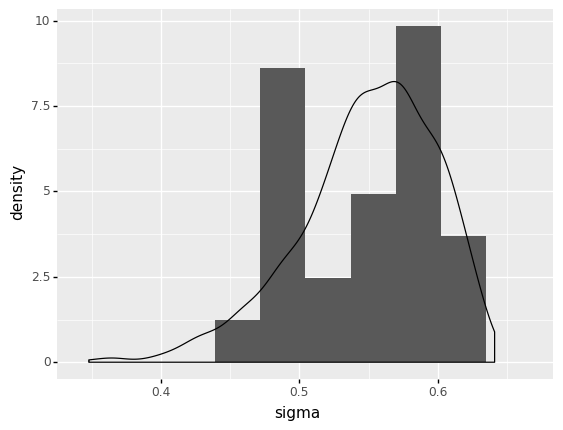

<ggplot: (8768217430538)>

In [6]:
## Fit a model
md_weibull = (
    gr.Model()
    >> gr.cp_marginals(
        sigma=gr.marg_fit("weibull_max", df_weibull.sigma)
    )
    >> gr.cp_copula_independence()
)

## Simulate observations from the model
(
    df_weibull
    >> gr.ggplot(gr.aes("sigma"))
    + gr.geom_histogram(gr.aes(y=gr.after_stat('density')), bins=10)
    + gr.geom_density(
        data=md_weibull
        >> gr.ev_sample(n=1e3, df_det="nom", skip=True, seed=101)
    )
)